# NLP1 LAB03

This notebook contains the work for the third lab of the NLP1 course.

Our work follows the structure of the lab description, which is as follows:
1. Features generation
2. Logistic regression

However, we added other sections to optimize our results. Everything is done using Pandas, but it is not optimized at all and slow (~30mins to generate train and test features on a MacBook Pro M1 laptop), so we advised to not run this cells. The first optimization is done in the "Optimize using PySpark" section, where we use distributed computing to speed up the process (takes ~4mins to do the same computation). The second optimization is done in the "Optimize using numpy arrays" section, where we vectorize the computation to speed up the process (takes ~1min to do the same computation).

Results are the same for all the sections, the only difference is the time it takes to generate the features. So you can omit reading the "Optimize using PySpark" and "Optimize using numpy arrays" sections if you don't want to read about optimization. Answers to the questions are detailled in the default sections using Pandas.

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np

In [ ]:
dataset = load_dataset("imdb")

## Features

### Preprocessing

First, we need to preprocess the data. We will use the same preprocessing as in the previous lab.

In [10]:
from string import punctuation
import re

def preprocess(df: pd.DataFrame) -> pd.DataFrame :
    """
    Preprocess the dataset by lowercasing the text and removing the punctuation manually

    Parameters
    ----------
    df : pd.DataFrame
        The dataset to preprocess

    Returns
    -------
    pd.DataFrame
        The preprocessed dataset
    """
    # First lower the case
    df["document"] = df["document"].apply(lambda x: x.lower())
    # Replace the punctuation with spaces. We keep the ' - that may give revelant informations
    # Replace HTML tag <br />
    punctuation_to_remove = '|'.join(map(re.escape, sorted(list(filter(lambda p: p != "'" and p != '-' and p != "!" and p != "?", punctuation)), reverse=True)))
    df["document"] = df["document"].apply(lambda x: re.sub(punctuation_to_remove, " ", x.replace('<br />', "")))
    # Remove the multiple spaces
    df["document"] = df["document"].apply(lambda x: re.sub(' +', ' ', x))
    # Remove the leading and trailing whitespaces
    df["document"] = df["document"].apply(lambda x: x.strip())
    return df

In [11]:
train_raw = pd.DataFrame(dataset["train"], columns=["text", "label"]).rename(columns={"text": "document", "label": "class"})
preprocessed_train = preprocess(train_raw)
test_raw = pd.DataFrame(dataset["test"], columns=["text", "label"]).rename(columns={"text": "document", "label": "class"})
preprocessed_test = preprocess(test_raw)

Load lexicon and keep only interesting tokens (one above the treshold)

In [12]:
threshold = 1
lexicon = pd.read_csv("vader_lexicon.txt", sep="\t", names=['Token', "Score", "Std", "Vector"]).drop(columns=["Std", "Vector"]).set_index("Token")
lexicon = lexicon[(lexicon["Score"] <= -threshold) | (lexicon["Score"] >= threshold)]

#### Generate the following features:
- 1 if "no" appears in the document, 0 otherwise.
- The count of first and second pronouns in the document.
- 1 if "!" is in the document, 0 otherwise.
- Log(word count in the document).
- Number of words in the document which are in the positive lexicon.
- Number of words in the document which are in the negative lexicon.
- [Bonus] Add another feature of your choice.

Our bonus feature is counting questions marks in the document. However, we will not use it in the rest of the lab, but we would use exactly the same process to use it

In [59]:
def is_in_lexicon(word: str, positive: bool):
    try:
        score = lexicon.at[word, "Score"].item()
        return score >= threshold if positive else score <= -threshold
    except:
        return False

def generate_features(dataset: pd.DataFrame) -> pd.DataFrame :
    """
    Generate the features for the dataset

    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset to generate the features for

    Returns
    -------
    pd.DataFrame
        The dataset with the features
    """
    dataset["no"] = dataset["document"].apply(lambda x: 1 if "no" in x.split() else 0)
    dataset["pronouns"] = dataset["document"].apply(lambda x: x.split()).apply(lambda x: x.count("i") + x.count("we") + x.count("you"))
    dataset["exclamation"] = dataset["document"].apply(lambda x: 1 if "!" in x else 0)
    dataset["log_word_count"] = dataset["document"].apply(lambda x: np.log(len(x.split())))
    dataset["positive_lexicon"] = dataset["document"].apply(lambda x: len(list(filter(lambda w: is_in_lexicon(w, True), x.split()))))
    dataset["negative_lexicon"] = dataset["document"].apply(lambda x: len(list(filter(lambda w: is_in_lexicon(w, False), x.split()))))
    # feature to count number of ? marks
    dataset["question_mark"] = dataset["document"].apply(lambda x: x.count("?"))

    # add feature vector column
    dataset["feature_vector"] = dataset.apply(lambda x: [x["no"], x["pronouns"], x["exclamation"], x["log_word_count"], x["positive_lexicon"], x["negative_lexicon"], x["question_mark"]], axis=1)
    # drop the other columns
    dataset = dataset.drop(columns=["no", "pronouns", "exclamation", "log_word_count", "positive_lexicon", "negative_lexicon", "question_mark"])

    return dataset

Using smaller datasets for training and testing, we can check the features generated.

In [60]:
reduced_train = preprocessed_train.iloc[::100].copy()
reduced_train = generate_features(reduced_train)

reduced_test = preprocessed_test.iloc[::100].copy()
reduced_test = generate_features(reduced_test)

reduced_train["feature_vector"][0]

[1, 7, 0, 5.655991810819852, 7, 6, 0]

The features look good. We can wrap all this processing in a class to make it easier in the future.

In [8]:
from abc import ABC, abstractmethod
from string import punctuation
import re

class DatasetManager(ABC):
    """
    Abstract class to manage the dataset
    
    Methods
    -------
    _raw_dataset(split: str) -> pd.DataFrame
        Return the raw dataset as a pandas dataframe
    preprocess(df: pd.DataFrame) -> pd.DataFrame
        Preprocess the dataset by lowercasing the text and removing the punctuation manually
    """
    @abstractmethod
    def _raw_dataset(self, split: str) -> pd.DataFrame:
        raise NotImplementedError()
    
    @abstractmethod
    def preprocess(self, df: pd.DataFrame) -> pd.DataFrame :
        raise NotImplementedError()
    
    @abstractmethod
    def generate_features(self, dataset) :
        raise NotImplementedError()


class IMDBDataset(DatasetManager):
    """
    Class to manage the IMDB dataset using Pandas

    Parameters
    ----------
    dataset : dict
        The dataset to manage

    Attributes
    ----------
    dataset : dict
        The dataset to manage
    train_raw : pd.DataFrame
        The raw train dataset
    test_raw : pd.DataFrame
        The raw test dataset
    train : pd.DataFrame
        The preprocessed train dataset
    test : pd.DataFrame 
        The preprocessed test dataset
    lexicon : pd.DataFrame
        The lexicon used to generate the features
    """
    def __init__(self, dataset: dict):
        self.dataset = dataset
        self.train_raw = self._raw_dataset("train")
        self.test_raw = self._raw_dataset("test")
        self.train = self.preprocess(self.train_raw)
        self.test = self.preprocess(self.test_raw)
    
    def _raw_dataset(self, split: str) -> pd.DataFrame:
        """
        Return the raw dataset as a pandas dataframe

        Parameters
        ----------
        split : str
            The split of the dataset to return

        Returns
        -------
        pd.DataFrame
            The raw dataset as a pandas dataframe
        """
        return pd.DataFrame(dataset[split], columns=["text", "label"]).rename(columns={"text": "document", "label": "class"})
    
    def preprocess(self, df: pd.DataFrame) -> pd.DataFrame :
        """
        Preprocess the dataset by lowercasing the text and removing the punctuation manually

        Parameters
        ----------
        df : pd.DataFrame
            The dataset to preprocess

        Returns
        -------
        pd.DataFrame
            The preprocessed dataset
        """
        # First lower the case
        df["document"] = df["document"].apply(lambda x: x.lower())
        # Replace the punctuation with spaces. We keep the ' - that may give revelant informations
        # Replace HTML tag <br />
        punctuation_to_remove = '|'.join(map(re.escape, sorted(list(filter(lambda p: p != "'" and p != '-' and p != "!", punctuation)), reverse=True)))
        df["document"] = df["document"].apply(lambda x: re.sub(punctuation_to_remove, " ", x.replace('<br />', "")))
        # Remove the multiple spaces
        df["document"] = df["document"].apply(lambda x: re.sub(' +', ' ', x))
        # Remove the leading and trailing whitespaces
        df["document"] = df["document"].apply(lambda x: x.strip())
        return df

    def add_lexicon(self, lexicon: pd.DataFrame, threshold: int = 1) -> None:
        """
        Add the lexicon to the dataset

        Parameters
        ----------
        lexicon : pd.DataFrame
            The lexicon to add
        threshold : int, optional
            The threshold to use to add the lexicon, by default 1

        Returns
        -------
        None
        """
        self.lexicon = lexicon[(lexicon["Score"] <= -threshold) | (lexicon["Score"] >= threshold)]

    def is_in_lexicon(self, word: str, positive: bool):
        """
        Check if the word is in the lexicon

        Parameters
        ----------
        word : str
            The word to check
        positive : bool
            If the word should be positive or negative

        Returns
        -------
        bool
            True if the word is in the lexicon, False otherwise
        """
        try:
            score = lexicon.at[word, "Score"].item()
            return score >= threshold if positive else score <= -threshold
        except:
            return False

    def generate_features(self, df: pd.DataFrame) -> None :
        """
        Generate the features for the dataset

        Parameters
        ----------
        df : pd.DataFrame
            The dataset to generate the features for
        """
        df["no"] = df["document"].apply(lambda x: 1 if "no" in x.split() else 0)
        df["pronouns"] = df["document"].apply(lambda x: x.split()).apply(lambda x: x.count("i") + x.count("we") + x.count("you"))
        df["exclamation"] = df["document"].apply(lambda x: 1 if "!" in x else 0)
        df["log_word_count"] = df["document"].apply(lambda x: np.log(len(x.split())))
        df["positive_lexicon"] = df["document"].apply(lambda x: len(list(filter(lambda w: is_in_lexicon(w, True), x.split()))))
        df["negative_lexicon"] = df["document"].apply(lambda x: len(list(filter(lambda w: is_in_lexicon(w, False), x.split()))))

        # add feature vector column
        df["feature_vector"] = df.apply(lambda x: [x["no"], x["pronouns"], x["exclamation"], x["log_word_count"], x["positive_lexicon"], x["negative_lexicon"]], axis=1)
        # drop the other columns
        df = df.drop(columns=["no", "pronouns", "exclamation", "log_word_count", "positive_lexicon", "negative_lexicon"])
        return df

Let's do the all process again using the full dataset and our new class.

IMPORTANT: The following code will take a long time to run. We optimized it in two ways:
- Using PySpark to parallelize the processing (see section "Optimize with PySpark").
- Using vectorization on numpy arrays (see section "Optimize with numpy arrays").

We commited to using Pandas in a first place, so let's see how it performs.

In [30]:
%%time

imdb_dataset = IMDBDataset(dataset)
lexicon = pd.read_csv("vader_lexicon.txt", sep="\t", names=['Token', "Score", "Std", "Vector"]).drop(columns=["Std", "Vector"]).set_index("Token")
imdb_dataset.add_lexicon(lexicon, threshold=1)
imdb_dataset.train = imdb_dataset.generate_features(imdb_dataset.train.copy())
imdb_dataset.test = imdb_dataset.generate_features(imdb_dataset.test.copy())

CPU times: user 28min 58s, sys: 8.94 s, total: 29min 6s
Wall time: 29min 6s


It takes ~30mins to get all the features, which is too long. That's why we will use PySpark to parallelize the processing and numpy to vectorize the features in the next sections (after "Logistic Regression classifier").

## Logistic regression classifier

#### Question 1
Adapt the code by adding your feature extractor and train a classifier

In [31]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [32]:
class LinearRegression(nn.Module):
    """A linear regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        self.linear = nn.Linear(input_dim, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of the linear layer.
        """
        return self.linear(x)

In [49]:
model = LinearRegression(6, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

Split the data into training and test sets.

In [50]:
features_train = imdb_dataset.train["feature_vector"]
features_train = np.array(features_train.to_list())
labels_train = imdb_dataset.train["class"].to_numpy()

features_train = torch.tensor(features_train, dtype=torch.float32)
labels_train = torch.tensor(labels_train, dtype=torch.float32).reshape(-1, 1)

X_train, X_valid, y_train, y_valid = train_test_split(
    features_train,
    labels_train,
    test_size=0.15,
    stratify=labels_train,
    random_state=42,
)

Let's do the same feature engineering for the test set

In [51]:
features_test = imdb_dataset.test["feature_vector"]
features_test = np.array(features_test.to_list())
X_test = torch.tensor(features_test, dtype=torch.float32)

labels_test = imdb_dataset.test["class"].to_numpy()
y_test = torch.tensor(labels_test, dtype=torch.float32).reshape(-1, 1)

In [52]:
n_epochs = 1000

# Keeping an eye on the losses
train_losses = []
test_losses = []

def train(log: bool = True): 
    # Training loop
    for epoch in range(n_epochs):
        # Setting all gradients to zero.
        optimizer.zero_grad()

        # Sending the whole training set through the model.
        predictions = model(X_train)
        # Computing the loss.
        loss = criterion(predictions, y_train)
        train_losses.append(loss.item())
        if log and epoch % 100 == 0:
            print(loss)
        # Computing the gradients and gradient descent.
        loss.backward()
        optimizer.step()

        # When computing the validation loss, we do not want to update the weights.
        # torch.no_grad tells PyTorch to not save the necessary data used for
        # gradient descent.
        with torch.no_grad():
            predictions = model(X_valid)
            loss = criterion(predictions, y_valid)
            test_losses.append(loss)

train()

tensor(1.0033, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5846, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5831, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5833, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5835, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5836, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5837, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5837, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5838, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5838, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


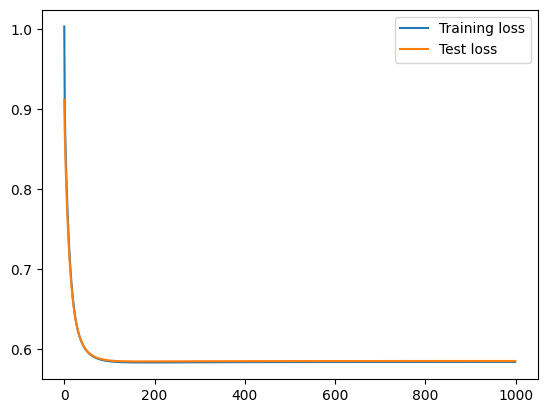

In [53]:
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()
plt.show()

#### Question 2
Evaluate your classifier in terms of accuracy for the training, validation, and test set.

In [54]:
with torch.no_grad():
    p_train = torch.sigmoid(model(X_train))
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = torch.sigmoid(model(X_valid))
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = torch.sigmoid(model(X_test))
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())

print(f"Training accuracy: {training_accuracy}")
print(f"Validation accuracy: {valid_accuracy}")
print(f"Test accuracy: {test_accuracy}")

Training accuracy: 0.7150117647058823
Validation accuracy: 0.7029333333333333
Test accuracy: 0.71356


#### Accuracy of PyTorch classifier

- Accuracy on the training set: 0.7150117647058823
- Accuracy on the validation set: 0.7029333333333333
- Accuracy on the test set: 0.71356

Results are not very satisfying, our Naive Bayes classifier was better... This can be explained by the fact that the features are not very discriminative.

#### Question 3
Look at the weights of your classifier. Which features seems to play most for both classes ?

In [45]:
# Let's look at the weights of the linear layer
weights = model.linear.weight.detach().numpy()
print(weights)
print(np.argmax(weights))

[[-0.02953346 -0.04086162 -0.00774549 -0.01823246  0.12862307 -0.15123938]]
4


The weights are the following:
[[-0.02953346 -0.04086162 -0.00774549 -0.01823246  0.12862307 -0.15123938]]

And the maximum weight is for the feature "number of words in the document which are in the positive lexicon".

The feature playing the most important role in the classification is the number of words in the document which are in the positive lexicon. This is not surprising as the positive lexicon contains words such as "good", "great", "excellent", etc. which are very indicative of a positive review.
Looking at absolute values, negative words are the most important. So we see that the lexicon is what gives the main direction to the classification.

#### Question 4 (Bonus)
The parameter weight_decay of the SGD optimizer corresponds to the L2 penalty. Try playing with this value and explain how it influence the model's weights

In [58]:
# The parameter weight_decay of the SGD optimizer corresponds to the L2 penalty. Try playing with this value and explain how it influence the model's weights

# change the weight decay to 0.1
model = LinearRegression(6, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.1)

# compute the weights again
train(log=False)
weights = model.linear.weight.detach().numpy()
print(weights)

# change the weight decay to 0.01
model = LinearRegression(6, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

# compute the weights again
train(log=False)
weights = model.linear.weight.detach().numpy()
print(weights)

[[-0.04503123 -0.04716688 -0.04168881 -0.04480998  0.1478644  -0.16958342]]
[[-0.05142881 -0.04810178 -0.19393842  0.01000327  0.15164183 -0.17712247]]


Here is how the weights change with the L2 penalty:
- 0.5: [[-0.02953346 -0.04086162 -0.00774549 -0.01823246  0.12862307 -0.15123938]]
- 0.1: [[-0.04503123 -0.04716688 -0.04168881 -0.04480998  0.1478644  -0.16958342]]
- 0.01: [[-0.05142881 -0.04810178 -0.19393842  0.01000327  0.15164183 -0.17712247]]

We can see that the weights are getting smaller with the L2 penalty. This is because the L2 penalty is a regularization term, which means that it will try to reduce the weights of the model to avoid overfitting. This is why the weights are getting smaller.
However, we see that the 3rd feature (number of exclamation marks) is much more important (in absolute value) with a weight decay of 0.01. More generally, it looks like the absolute value of this feature is increasing with the weight decay decreasing. This is easy to see on the 3rd feature but this is an overall trend. The L2 penalty is a regularization term, which means that it will try to reduce the weights of the model to avoid overfitting. This is why the weights are getting smaller when increasing the L2 penalty.


#### Question 5
Take two wrongly classified samples in the test set and try explaining why the model was wrong.

In [46]:
# Take two wrongly classified samples in the test set and try explaining why the model was wrong.
wrongly_classified = np.where(p_test != y_test.numpy())[0]

# Let's look at the first wrongly classified sample
print(imdb_dataset.test.iloc[wrongly_classified[0]]["document"][:100])

# Let's look at the second wrongly classified sample
print(imdb_dataset.test.iloc[wrongly_classified[1]]["document"][:100])

first off let me say if you haven't enjoyed a van damme movie since bloodsport you probably will not
isaac florentine has made some of the best western martial arts action movies ever produced in parti


The two wrongly classified examples are the following:

1. *first off let me say if you haven't enjoyed a van damme movie since bloodsport you probably will not like this movie most of these movies may not have the best plots or best actors but i enjoy these kinds of movies for what they are this movie is much better than any of the movies the other action guys segal and dolph have thought about putting out the past few years van damme is good in the movie the movie is only worth watching to van damme fans it is not as good as wake of death which i highly recommend to anyone of likes van damme or in hell but in my opinion it's worth watching it has the same type of feel to it as nowhere to run good fun stuff!*

2. *isaac florentine has made some of the best western martial arts action movies ever produced in particular us seals 2 cold harvest special forces and undisputed 2 are all action classics you can tell isaac has a real passion for the genre and his films are always eventful creative and sharp affairs with some of the best fight sequences an action fan could hope for in particular he has found a muse with scott adkins as talented an actor and action performer as you could hope for this is borne out with special forces and undisputed 2 but unfortunately the shepherd just doesn't live up to their abilities there is no doubt that jcvd looks better here fight-wise than he has done in years especially in the fight he has for pretty much no reason in a prison cell and in the final showdown with scott but look in his eyes jcvd seems to be dead inside there's nothing in his eyes at all it's like he just doesn't care about anything throughout the whole film and this is the leading man there are other dodgy aspects to the film script-wise and visually but the main problem is that you are utterly unable to empathise with the hero of the film a genuine shame as i know we all wanted this film to be as special as it genuinely could have been there are some good bits mostly the action scenes themselves this film had a terrific director and action choreographer and an awesome opponent for jcvd to face down this could have been the one to bring the veteran action star back up to scratch in the balls-out action movie stakes sincerely a shame that this didn't happen*

They are both of class 0, but are classified as 1.

Their features vectors are the following:

1. [0, 4, 1, 4.897839799950911, 12, 2]
2. [1, 5, 0, 5.666426688112432, 21, 11]

These wrondly classified examples are mostly positive reviews which are classified as negative. This is surely because they are really hard to classify, mixing positive and negative parts. In the first one: 'if you haven't enjoyed a van damme movie since bloodsport you probably will not like this movie' is negative when read on its own, but positive when read in the context of the whole review. The second one also contains negative or mixed parts inside the whole review, which is very confusing for the classifier.

Another point might be that these reviews contains a short summary of the movie, with a description of the plot, which is not very indicative of the review itself. These descriptions contain a lot of negative words (such as "dead", "fight", "blood", ...), which can lead to a wrong classification.

#### Cleaning and refactoring

Let's wrap the classifier inside a class to make it easier to use.

In [24]:
from typing import List

class ClassifierWrapper():
    """
    A wrapper around a classifier to make it compatible with the DatasetManager
    """
    random_state = 42

    def __init__(self, model: nn.Module, criterion, optimizer, dataset_manager: DatasetManager):
        """
        Args:
            model: the model to train.
            criterion: the loss function.
            optimizer: the optimizer.
            dataset_manager: the dataset manager.
        """
        self.model = model
        self.dataset_manager = dataset_manager
        self.criterion = criterion
        self.optimizer = optimizer
        self._extract_features()
        self.X_train, self.X_valid, self.y_train, self.y_valid = self._split_train_valid()
    

    def _extract_features(self):
        """
        Extracts the features and labels from the dataset manager
        """
        self.features_train = self.dataset_manager.train["feature_vector"]
        self.features_train = np.array(self.features_train.to_list()).astype(np.float32)
        self.features_train = torch.tensor(self.features_train, dtype=torch.float32)
        self.labels_train = self.dataset_manager.train["class"].to_numpy()
        self.labels_train = torch.tensor(self.labels_train, dtype=torch.float32).reshape(-1, 1)

        self.features_test = self.dataset_manager.test["feature_vector"]
        self.features_test = np.array(self.features_test.to_list()).astype(np.float32)
        self.features_test = torch.tensor(self.features_test, dtype=torch.float32)
        self.labels_test = self.dataset_manager.test["class"].to_numpy()
        self.labels_test = torch.tensor(self.labels_test, dtype=torch.float32).reshape(-1, 1)


    def _split_train_valid(self, test_size: float = 0.15) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Splits the training set into training and validation sets

        Parameters
        ----------
        test_size : float, optional
            The proportion of the training set to use for validation, by default 0.15

        Returns
        -------
        X_train, X_valid, y_train, y_valid : torch.Tensor
            The training and validation sets
        """
        X_train, X_valid, y_train, y_valid = train_test_split(
            self.features_train,
            self.labels_train,
            test_size=test_size,
            stratify=self.labels_train,
            random_state=self.random_state,
        )
        return X_train, X_valid, y_train, y_valid


    def fit(self, X: torch.Tensor = None, y: torch.Tensor = None, n_epochs: int = 1000) -> tuple[List[float], List[float]]:
        """
        Fits the model

        Parameters
        ----------
        X : torch.Tensor, optional
            The training set. If None, the training set from the dataset manager is used, by default None
        y : torch.Tensor, optional
            The labels of the training set. If None, the labels from the dataset manager are used, by default None
        n_epochs : int, optional
            The number of epochs to train for, by default 1000

        Returns
        -------
        train_losses, test_losses : List[float]
            The losses of the training and validation sets
        """
        if X is None:
            X = self.X_train
        if y is None:
            y = self.y_train

        train_losses = []
        test_losses = []
        for epoch in range(n_epochs):
            self.optimizer.zero_grad()
            predictions = self.model(X)
            loss = self.criterion(predictions, y)
            train_losses.append(loss.item())
            if epoch % 100 == 0:
                print(loss)
            loss.backward()
            self.optimizer.step()

            with torch.no_grad():
                predictions = self.model(self.X_valid)
                loss = self.criterion(predictions, self.y_valid)
                test_losses.append(loss)

        self.train_losses = train_losses
        self.test_losses = test_losses


    def plot_losses(self):
        """
        Plots the losses of the training and validation sets
        """
        plt.plot(np.arange(len(self.train_losses)), self.train_losses, label="Training loss")
        plt.plot(np.arange(len(self.test_losses)), self.test_losses, label="Test loss")
        plt.legend()
        plt.show()
    

    def predict(self, X: torch.Tensor) -> torch.Tensor:
        """
        Predicts the labels of the given data

        Parameters
        ----------
        X : torch.Tensor
            The data to predict

        Returns
        -------
        p : torch.Tensor
            The predictions
        """
        with torch.no_grad():
            p = torch.sigmoid(self.model(X))
            p = np.round(p.numpy())
            return p
    
    def evaluate(self, X: torch.Tensor, y: torch.Tensor) -> float:
        """
        Evaluates the model on the given data

        Parameters
        ----------
        X : torch.Tensor
            The data
        y : torch.Tensor
            The labels

        Returns
        -------
        accuracy : float
            The accuracy of the model
        """
        p = self.predict(X)
        accuracy = np.mean(p == y.numpy())
        return accuracy

In [91]:
# reinitialize the model
model = LinearRegression(6, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

classifier = ClassifierWrapper(model, criterion, optimizer, imdb_dataset)
classifier.fit()

tensor(1.1071, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5893, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5860, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5849, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5844, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5842, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5840, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5839, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5839, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5838, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


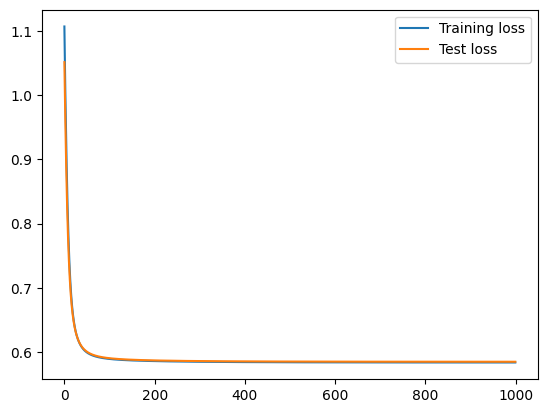

In [92]:
classifier.plot_losses()

In [93]:
print("Accuracy on the training set:", classifier.evaluate(classifier.X_train, classifier.y_train))
print("Accuracy on the validation set:", classifier.evaluate(classifier.X_valid, classifier.y_valid))
print("Accuracy on the test set:", classifier.evaluate(classifier.features_test, classifier.labels_test))

Accuracy on the training set: 0.7149176470588235
Accuracy on the validation set: 0.7026666666666667
Accuracy on the test set: 0.71364


Obviously the results are the same (everything is just wrapped in a class). Let's see if we can improve it by using a different classifier.

#### Question 6
Train logistic regression classifier using the scikit-learn implementation. How does it compare with the PyTorch version?

In [95]:
# use scikit-learn and compare the results
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# convert the features to numpy array
X_train = np.array(imdb_dataset.train["feature_vector"].tolist())
X_test = np.array(imdb_dataset.test["feature_vector"].tolist())

# convert the labels to numpy array
y_train = np.array(imdb_dataset.train["class"].tolist())
y_test = np.array(imdb_dataset.test["class"].tolist())

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    stratify=y_train,
    random_state=42,
)

# initialize the model
model = LogisticRegression()

# fit the model
model.fit(X_train, y_train)

# predict the labels
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)
y_pred_test = model.predict(X_test)

# calculate the accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Accuracy on the training set:", train_accuracy)
print("Accuracy on the validation set:", valid_accuracy)
print("Accuracy on the test set:", test_accuracy)

Accuracy on the training set: 0.7150117647058823
Accuracy on the validation set: 0.7064
Accuracy on the test set: 0.71292


Results with sklearn's LogisticRegression:
- Accuracy on the training set: 0.7150117647058823
- Accuracy on the validation set: 0.7064
- Accuracy on the test set: 0.71292

Results are approximately the same between PyThorch's implementation and sklearn's one.

## Optimize using PySpark

It takes too much time to preprocess the data with Pandas, so we will use PySpark instead.
To do so, we will create a new DatasetManager class which will use PySpark to load the data and generate the features.

This part is a duplicate version of the previous one, results will not be analyzed in details, all questions are answered in the previous section.

In a first place, we will detail separatly each step of the preprocessing, to make it easier to understand.

In [96]:
# let's use pyspark to preprocess the data
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.dataframe as pyspark_df
from pyspark.sql.functions import udf

spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/04 16:07:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/04 16:07:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Now, we need to do the same preprocessing as before, which means:
- lowercasing
- removing punctuation (except ' ! and -)
- remove extra spaces

In [98]:
def preprocess_spark(dataset: pd.DataFrame) -> pd.DataFrame :
    """
    Preprocess the dataset by lowercasing the text and removing the punctuation manually using spark

    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset to preprocess

    Returns
    -------
    pd.DataFrame
        The preprocessed dataset
    """
    # First lower the case
    dataset = dataset.withColumn("document", F.lower(F.col("document")))
    # Replace the punctuation with spaces. We keep the ' - and ! that may give revelant informations
    # Replace HTML tag <br />
    dataset = dataset.withColumn("document", F.regexp_replace(F.col("document"), r"[^a-zA-Z0-9\s-!]", " "))
    dataset = dataset.withColumn("document", F.regexp_replace(F.col("document"), r"<br />", " "))
    # Remove the extra spaces
    dataset = dataset.withColumn("document", F.regexp_replace(F.col("document"), r"\s+", " "))
    return dataset

Loading the datasets and the lexicon is the next step. We will use the same lexicon as before, but we will load it as a Spark dataframe.
Also, we will separate the positive and negative lexicons into two different dataframes because we will need them later.

In [99]:
# Let's create a spark dataframe from the dataset and preprocess it
preprocessed_train_spark = preprocess_spark(spark.createDataFrame(dataset["train"], schema=["class", "document"]))
preprocessed_test_spark = preprocess_spark(spark.createDataFrame(dataset["test"], schema=["class", "document"]))

threshold = 1

# read the lexicon and filter it
lexicon_spark = spark.read.csv("vader_lexicon.txt", sep="\t", header=False, inferSchema=True)
lexicon_spark = lexicon_spark.withColumnRenamed("_c0", "Token").withColumnRenamed("_c1", "Score")
lexicon_spark = lexicon_spark.drop("_c2", "_c3")
lexicon_spark = lexicon_spark.filter((F.col("Score") <= -threshold) | (F.col("Score") >= threshold))

positive_lexicon_spark = lexicon_spark.filter(F.col("Score") >= threshold)
# convert it to a list
positive_lexicon_list = positive_lexicon_spark.select("Token").rdd.flatMap(lambda x: x).collect()

negative_lexicon_spark = lexicon_spark.filter(F.col("Score") <= -threshold)
# convert it to a list
negative_lexicon_list = negative_lexicon_spark.select("Token").rdd.flatMap(lambda x: x).collect()

It's time to generate the features. We will use the same features as before, but we will use Spark to generate them. This is where we will use the different lexicons.

In [100]:
from pyspark.sql.functions import udf

@udf(returnType='int')
def cnt_no(s):
    return 1 if s.count("no") > 0 else 0

@udf(returnType='int')
def cnt_pronouns(s):
    return s.count('i') + s.count('you') + s.count('we')

def cnt_lex(tokens):
    return udf(lambda s: cate(s, tokens))

def cate(s, tokens):
    return sum([1 for w in s if w in tokens])

def generate_features_spark(df: pyspark_df.DataFrame) -> pyspark_df.DataFrame:
    """
    Generate the features for the dataset

    Parameters
    ----------
    df : pyspark_df.DataFrame
        The dataset to generate the features for

    Returns
    -------
    pyspark_df.DataFrame
        The dataset with the features
    """
    # check if "no" is in the document
    df = df.withColumn("no", cnt_no(F.split(F.col("document"), " ")))
    # The count of first and second pronouns in the document.
    df = df.withColumn("pronouns", cnt_pronouns(F.split(F.col("document"), " ")))
    # 1 if "!" is in the document, 0 otherwise.
    df = df.withColumn("exclamation", F.when(F.col("document").contains("!"), 1).otherwise(0))
    # Log(word count in the document).
    df = df.withColumn("log_word_count", F.log(F.size(F.array_distinct(F.split(F.col("document"), " ")))))
    # Number of words in the document which are in the positive lexicon (score >= 1 in the lexicon_spark dataframe)
    df = df.withColumn("positive_lexicon", cnt_lex(positive_lexicon_list)(F.split(F.col("document"), " ")))
    # Number of words in the document which are in the negative lexicon (score <= -1 in the lexicon_spark dataframe)
    df = df.withColumn("negative_lexicon", cnt_lex(negative_lexicon_list)(F.split(F.col("document"), " ")))

    # create a new column with all these values in a list
    df = df.withColumn("feature_vector", F.array("no", "pronouns", "exclamation", "log_word_count", "positive_lexicon", "negative_lexicon"))
    # drop the columns we don't need anymore
    df = df.drop("no", "pronouns", "exclamation", "log_word_count", "positive_lexicon", "negative_lexicon")
    return df

In [102]:
features_train_spark = generate_features_spark(preprocessed_train_spark)
features_test_spark = generate_features_spark(preprocessed_test_spark)

Now, we can wrap everything in a class inheriting from DatasetManager. 

In [103]:
@udf(returnType='int')
def _cnt_no(s):
    """
    Spark UDF to count the number of "no" in the document
    """
    return 1 if s.count("no") > 0 else 0

@udf(returnType='int')
def _cnt_pronouns(s):
    """
    Spark UDF to count the number of first and second pronouns in the document
    """
    return s.count('i') + s.count('you') + s.count('we')

def _cate(s, tokens):
    """
    Spark UDF to count the number of words in the document that are in the lexicon
    """
    return sum([1 for w in s if w in tokens])

def _cnt_lex(tokens):
    """
    Hat function to return a function that counts the number of words in the document that are in the lexicon using spark UDF
    """
    return udf(lambda s: _cate(s, tokens))

class IMDBDatasetSpark(DatasetManager):
    """
    A class to manage the IMDB dataset using pyspark
    
    Parameters
    ----------
    dataset : dict
        The dataset to manage
        
    Attributes
    ----------
    dataset : dict
        The dataset to manage
    spark_train_raw : pyspark_df.DataFrame
        The raw training set
    spark_test_raw : pyspark_df.DataFrame
        The raw test set
    train : pyspark_df.DataFrame
        The preprocessed training set
    test : pyspark_df.DataFrame
        The preprocessed test set
    lexicon : pyspark_df.DataFrame
        The lexicon used to deduce the features
    positive_lexicon : pyspark_df.DataFrame
        The positive elements of the lexicon
    negative_lexicon : pyspark_df.DataFrame
        The negative elements of the lexicon
    """
    def __init__(self, dataset: dict):
        self.dataset = dataset
        self.spark_train_raw = self._raw_dataset("train")
        self.spark_test_raw = self._raw_dataset("test")
        self.spark_train = self.preprocess(self.spark_train_raw)
        self.spark_test = self.preprocess(self.spark_test_raw)

    def _raw_dataset(self, split: str) -> pyspark_df.DataFrame:
        return spark.createDataFrame(dataset[split], schema=["class", "document"])
    
    def preprocess(self, df: pyspark_df.DataFrame) -> pyspark_df.DataFrame:
        """
        Preprocess the dataset by lowercasing the text and removing the punctuation manually using spark

        Parameters
        ----------
        df : pd.DataFrame
            The dataset to preprocess

        Returns
        -------
        pd.DataFrame
            The preprocessed dataset
        """
        # First lower the case
        df = df.withColumn("document", F.lower(F.col("document")))
        # Replace the punctuation with spaces. We keep the ' - that may give revelant informations
        # Replace HTML tag <br />
        df = df.withColumn("document", F.regexp_replace(F.col("document"), r"[^a-zA-Z0-9'-]", " "))
        df = df.withColumn("document", F.regexp_replace(F.col("document"), r"<br />", " "))
        # Remove the extra spaces
        df = df.withColumn("document", F.regexp_replace(F.col("document"), r"\s+", " "))
        return df
    

    def add_lexicon(self, lexicon: pyspark_df.DataFrame):
        """
        Add and compute the lexicon for the dataset.
        Separate the lexicon into positive and negative words and store them as lists

        Parameters
        ----------
        lexicon : pd.DataFrame
            The lexicon to add
        """
        lexicon = lexicon.withColumnRenamed("_c0", "Token").withColumnRenamed("_c1", "Score")
        lexicon = lexicon.drop("_c2", "_c3")
        lexicon = lexicon.filter((F.col("Score") <= -threshold) | (F.col("Score") >= threshold))
        self.lexicon = lexicon

        # We create a list of the positive and negative words
        positive_lexicon = self.lexicon.filter(F.col("Score") >= threshold)
        positive_lexicon_list = positive_lexicon.select("Token").rdd.flatMap(lambda x: x).collect()
        self.positive_lexicon = positive_lexicon_list

        negative_lexicon = self.lexicon.filter(F.col("Score") <= -threshold)
        negative_lexicon_list = negative_lexicon.select("Token").rdd.flatMap(lambda x: x).collect()
        self.negative_lexicon = negative_lexicon_list

    def generate_features(self, df: pyspark_df.DataFrame) -> pyspark_df.DataFrame:
        """
        Generate the features for the dataset

        Parameters
        ----------
        df : pyspark_df.DataFrame
            The dataset to generate the features for

        Returns
        -------
        pyspark_df.DataFrame
            The dataset with the features
        """
        # check if "no" is in the document
        df = df.withColumn("no", _cnt_no(F.split(F.col("document"), " ")))
        # The count of first and second pronouns in the document.
        df = df.withColumn("pronouns", _cnt_pronouns(F.split(F.col("document"), " ")))
        # 1 if "!" is in the document, 0 otherwise.
        df = df.withColumn("exclamation", F.when(F.col("document").contains("!"), 1).otherwise(0))
        # Log(word count in the document).
        df = df.withColumn("log_word_count", F.log(F.size(F.array_distinct(F.split(F.col("document"), " ")))))
        # Number of words in the document which are in the positive lexicon (score >= 1 in the lexicon_spark dataframe)
        df = df.withColumn("positive_lexicon", _cnt_lex(self.positive_lexicon)(F.split(F.col("document"), " ")))
        # Number of words in the document which are in the negative lexicon (score <= -1 in the lexicon_spark dataframe)
        df = df.withColumn("negative_lexicon", _cnt_lex(self.negative_lexicon)(F.split(F.col("document"), " ")))
        
        # create a new column with all these values in a list
        df = df.withColumn("feature_vector", F.array("no", "pronouns", "exclamation", "log_word_count", "positive_lexicon", "negative_lexicon"))
        # drop the columns we don't need anymore
        df = df.drop("no", "pronouns", "exclamation", "log_word_count", "positive_lexicon", "negative_lexicon")
        return df

    def convert_to_pandas(self) -> None:
        """
        Convert the spark_train and spark_test to pandas dataframe
        """
        self.train = self.spark_train.toPandas()
        self.test = self.spark_test.toPandas()

In [104]:
%%time

# initialize the spark dataset
imdb_dataset_spark = IMDBDatasetSpark(dataset)
lexicon_spark = spark.read.csv("vader_lexicon.txt", sep="\t", header=False, inferSchema=True)
imdb_dataset_spark.add_lexicon(lexicon_spark)
imdb_dataset_spark.spark_train = imdb_dataset_spark.generate_features(imdb_dataset_spark.spark_train)
imdb_dataset_spark.spark_test = imdb_dataset_spark.generate_features(imdb_dataset_spark.spark_test)
imdb_dataset_spark.convert_to_pandas()

Converting train set to pandas dataframe...
23/04/04 16:16:28 WARN TaskSetManager: Stage 9 contains a task of very large size (3893 KiB). The maximum recommended task size is 1000 KiB.


Converting test set to pandas dataframe...
23/04/04 16:17:56 WARN TaskSetManager: Stage 10 contains a task of very large size (3861 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 1.44 s, sys: 523 ms, total: 1.96 s
Wall time: 3min 1s


In [105]:
# reinitialize the model
model = LinearRegression(6, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

classifier = ClassifierWrapper(model, criterion, optimizer, imdb_dataset_spark)
classifier.fit()

tensor(0.9007, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5862, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5831, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5829, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5829, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5829, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5829, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5829, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5829, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5829, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


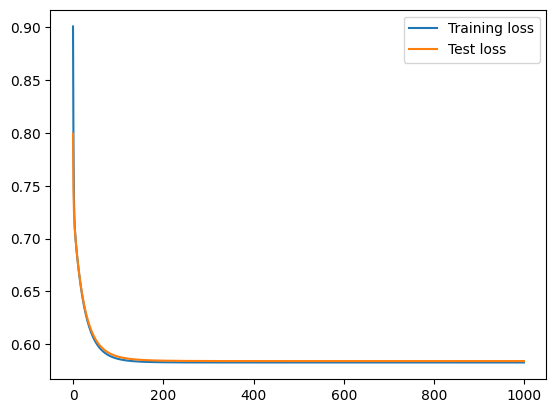

In [106]:
classifier.plot_losses()

In [107]:
print("Accuracy on the training set:", classifier.evaluate(classifier.X_train, classifier.y_train))
print("Accuracy on the validation set:", classifier.evaluate(classifier.X_valid, classifier.y_valid))
print("Accuracy on the test set:", classifier.evaluate(classifier.features_test, classifier.labels_test))

Accuracy on the training set: 0.7152
Accuracy on the validation set: 0.7026666666666667
Accuracy on the test set: 0.71316


Result with PySpark:
- Accuracy on the training set: 0.7152
- Accuracy on the validation set: 0.7026666666666667
- Accuracy on the test set: 0.71316

We get the similar results as before, so we can be sure that the classifier is working correctly. Also, using PySpark is much faster than using Pandas.

## Optimize using numpy arrays

Again, this part is a duplicate version of the previous one, results will not be analyzed in details, all questions are answered in the "Logistic Regression" section.

Let's rewrite the preprocessing and feature generation using numpy arrays instead of Pandas dataframes or Spark. This should be faster.

In [136]:
def preprocess(df) -> None:
    arr = np.vectorize(lambda x: x.lower(), signature='()->()')(df)
    # Replace the punctuation with spaces. We keep the ' - that may give revelant informations
    # Replace HTML tag <br />
    punctuation_to_remove = '|'.join(map(re.escape, sorted(list(filter(lambda p: p != "'" and p != '-' and p != "!", punctuation)), reverse=True)))
    arr = np.vectorize(lambda x: re.sub(punctuation_to_remove, " ", x.replace('<br />', "")), signature='()->()')(arr)
    # Remove the multiple spaces
    arr = np.vectorize(lambda x: re.sub(' +', ' ', x), signature='()->()')(arr)
    # Remove the leading and trailing whitespaces
    arr = np.vectorize(lambda x: x.strip(), signature='()->()')(arr)
    return arr.tolist()

train_documents = preprocess(dataset["train"]["text"])
test_documents = preprocess(dataset["test"]["text"])

Now for the big part: generating the features. We will use numpy arrays to do so.

In [137]:
lexicon = pd.read_csv("vader_lexicon.txt", sep="\t", names=['Token', "Score", "Std", "Vector"]).drop(columns=["Std", "Vector"]).set_index("Token").to_dict()["Score"]

def features_vector(doc: str, threshold: int = 1) -> pd.DataFrame:
    text = list(filter(lambda s : s != '', doc.split()))

    no_present = int('no' in text)
    pronouns_count = sum([word in ['i', 'you'] for word in text])
    exclamation_present = int('!' in text)
    log_word_count = np.log(len(text))
    sentiment_array = np.vectorize(lambda x: lexicon.get(x, 0.0))(text)
    positive_count = np.sum(sentiment_array >= threshold)
    negative_count = np.sum(sentiment_array <= -threshold)

    arr = np.array([
        no_present,
        pronouns_count,
        exclamation_present,
        log_word_count,
        positive_count,
        negative_count])
    return arr


In [138]:
# using np.vectorize to apply the function to each element of the array
features_train = np.vectorize(lambda x: features_vector(x), signature='()->(n)')(train_documents)
features_test = np.vectorize(lambda x: features_vector(x), signature='()->(n)')(test_documents)
features_train

array([[ 1.        ,  7.        ,  0.        ,  5.65599181,  7.        ,
         6.        ],
       [ 1.        ,  2.        ,  0.        ,  5.36597602,  5.        ,
         4.        ],
       [ 1.        ,  0.        ,  0.        ,  4.48863637,  3.        ,
         3.        ],
       ...,
       [ 0.        ,  2.        ,  0.        ,  4.87519732, 10.        ,
         3.        ],
       [ 0.        ,  2.        ,  0.        ,  5.6347896 ,  8.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  4.02535169,  2.        ,
         1.        ]])

Looks great! We will have to wrap it in a pandas dataframe to be able to use the LinearRegression class, but it's not a big deal.

In [139]:
features_train = pd.DataFrame({"document": train_documents, "feature_vector": features_train.tolist()})
features_test = pd.DataFrame({"document": test_documents, "feature_vector": features_test.tolist()})

As before, let's put everything in a class inheriting from DatasetManager.

In [17]:
class IMDBDatasetNumpy(DatasetManager):
    def __init__(self, dataset: dict):
        self.dataset = dataset
        self.train_raw = self._raw_dataset("train", "text")
        self.test_raw = self._raw_dataset("test", "text")
        self.train_labels = self._raw_dataset("train", "label")
        self.test_labels = self._raw_dataset("test", "label")
        self.train = self.preprocess(self.train_raw)
        self.test = self.preprocess(self.test_raw)
    
    def _raw_dataset(self, split: str, type: str) -> np.ndarray:
        """
        Return the raw dataset as a numpy array

        Parameters
        ----------
        split : str
            The split of the dataset to return
        type : str
            The type of the dataset to return

        Returns
        -------
        np.ndarray
            The raw dataset as a numpy array
        """
        return np.array(self.dataset[split][type])
    
    def preprocess(self, arr: np.ndarray) -> np.ndarray:
        """
        Preprocess the dataset by lowercasing the text and removing the punctuation manually

        Parameters
        ----------
        arr : np.ndarray
            The dataset to preprocess

        Returns
        -------
        np.ndarray
            The preprocessed dataset
        """
        # First lower the case
        arr = np.vectorize(lambda x: x.lower(), signature='()->()')(arr)
        # Replace the punctuation with spaces. We keep the ' - that may give revelant informations
        # Replace HTML tag <br />
        punctuation_to_remove = '|'.join(map(re.escape, sorted(list(filter(lambda p: p != "'" and p != '-' and p != "!", punctuation)), reverse=True)))
        arr = np.vectorize(lambda x: re.sub(punctuation_to_remove, " ", x.replace('<br />', "")), signature='()->()')(arr)
        # Remove the multiple spaces
        arr = np.vectorize(lambda x: re.sub(' +', ' ', x), signature='()->()')(arr)
        # Remove the leading and trailing whitespaces
        arr = np.vectorize(lambda x: x.strip(), signature='()->()')(arr)
        return arr

    def add_lexicon(self, lexicon: pd.DataFrame, threshold: int = 1):
        """
        Add the lexicon to the dataset

        Parameters
        ----------
        lexicon : pd.DataFrame
            The lexicon to add to the dataset
        """
        self.lexicon = lexicon[(lexicon["Score"] <= -threshold) | (lexicon["Score"] >= threshold)].to_dict()["Score"]

    def _features_vector(self, doc: str, threshold: int = 1) -> np.ndarray:
        """
        Generate the features for the dataset

        Parameters
        ----------
        doc : str
            The document to extract the features from
        threshold : int, optional
            The threshold to use to extract the features, by default 1

        Returns
        -------
        np.ndarray
            The features as a numpy array
        """
        text = list(filter(lambda s : s != '', doc.split()))
        no = int('no' in text)
        pronouns_count = sum([word in ['i', 'you'] for word in text])
        exclamation_present = int('!' in text)
        word_count = np.log(len(text))
        sentiment_array = np.vectorize(lambda x: self.lexicon.get(x, 0.0))(text)
        positive_words = np.sum(sentiment_array >= threshold)
        negative_words = np.sum(sentiment_array <= -threshold)

        arr = np.array([no, pronouns_count, exclamation_present, word_count, positive_words, negative_words])
        return arr

    def generate_features(self, arr: np.ndarray) -> np.ndarray:
        """
        Generate the features for the dataset

        Parameters
        ----------
        arr : np.ndarray
            The dataset to generate the features for

        Returns
        -------
        np.ndarray
            The dataset with the features
        """
        features = np.vectorize(lambda x: self._features_vector(x), signature='()->(n)')(arr)
        res = np.empty(2, dtype=object)
        res[0] = arr
        res[1] = features
        return res
    
    def convert_to_pandas(self) -> pd.DataFrame:
        """
        Convert the dataset to a pandas DataFrame

        Returns
        -------
        pd.DataFrame
            The dataset as a pandas DataFrame
        """
        self.train = pd.DataFrame({"class": self.train_labels, "document": self.train[0], "feature_vector": self.train[1].tolist()})
        self.test = pd.DataFrame({"class": self.test_labels, "document": self.test[0], "feature_vector": self.test[1].tolist()})

In [18]:
imdb_dataset_numpy = IMDBDatasetNumpy(dataset)
lexicon = pd.read_csv("vader_lexicon.txt", sep="\t", names=['Token', "Score", "Std", "Vector"]).drop(columns=["Std", "Vector"]).set_index("Token")
imdb_dataset_numpy.add_lexicon(lexicon)
imdb_dataset_numpy.train = imdb_dataset_numpy.generate_features(imdb_dataset_numpy.train.copy())
imdb_dataset_numpy.test = imdb_dataset_numpy.generate_features(imdb_dataset_numpy.test.copy())
imdb_dataset_numpy.convert_to_pandas()

Let's just take a quick look at what we have

In [19]:
imdb_dataset_numpy.train[:5]

,class,document,feature_vector
0,0,i rented i am curious-yellow from my video sto...,"[1.0, 7.0, 0.0, 5.655991810819852, 7.0, 6.0]"
1,0,i am curious yellow is a risible and pretentio...,"[1.0, 2.0, 0.0, 5.365976015021851, 5.0, 4.0]"
2,0,if only to avoid making this type of film in t...,"[1.0, 0.0, 0.0, 4.48863636973214, 3.0, 3.0]"
3,0,this film was probably inspired by godard's ma...,"[0.0, 3.0, 0.0, 4.770684624465665, 5.0, 5.0]"
4,0,oh brother after hearing about this ridiculous...,"[0.0, 9.0, 0.0, 5.631211781821365, 3.0, 9.0]"


In [25]:
# reinitialize the model
model = LinearRegression(6, 1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

classifier = ClassifierWrapper(model, criterion, optimizer, imdb_dataset_numpy)
classifier.fit()

tensor(3.0225, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5877, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5844, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5836, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5833, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5831, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5831, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5830, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5830, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
tensor(0.5830, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


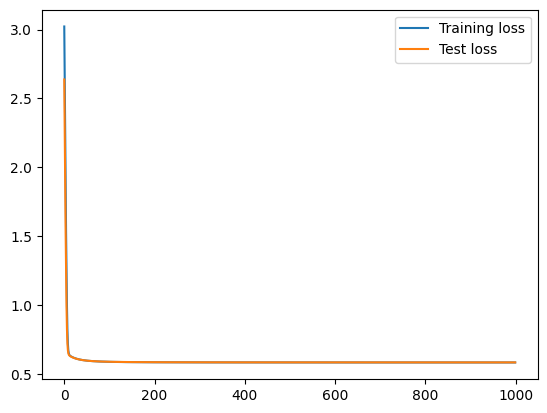

In [26]:
classifier.plot_losses()

In [27]:
print("Accuracy on the training set:", classifier.evaluate(classifier.X_train, classifier.y_train))
print("Accuracy on the validation set:", classifier.evaluate(classifier.X_valid, classifier.y_valid))
print("Accuracy on the test set:", classifier.evaluate(classifier.features_test, classifier.labels_test))

Accuracy on the training set: 0.7100705882352941
Accuracy on the validation set: 0.7010666666666666
Accuracy on the test set: 0.70052


Result with numpy arrays:
- Accuracy on the training set: 0.7100705882352941
- Accuracy on the validation set: 0.7010666666666666
- Accuracy on the test set: 0.70052

Again, we have similar result than with Pandas and PySpark. However, this solution is the fastest one, by far.